 
PARAMETERS: positve dip angle to tilt the fault to y+
PARAMETERS: negavtive dip to tilt the fault to y-
PARAMETERS: par.fzmin, par.ysource, par.zsource, par.dz, par.dt will be modified by mod4dip for dipping faults
If insertFaultType==2, an integer seedId to generate fractal fault is needed;
Please assign par.seedId accordingly.
Post-processing frt.txt0 ... ...
Post-processing frt.txt2 ... ...


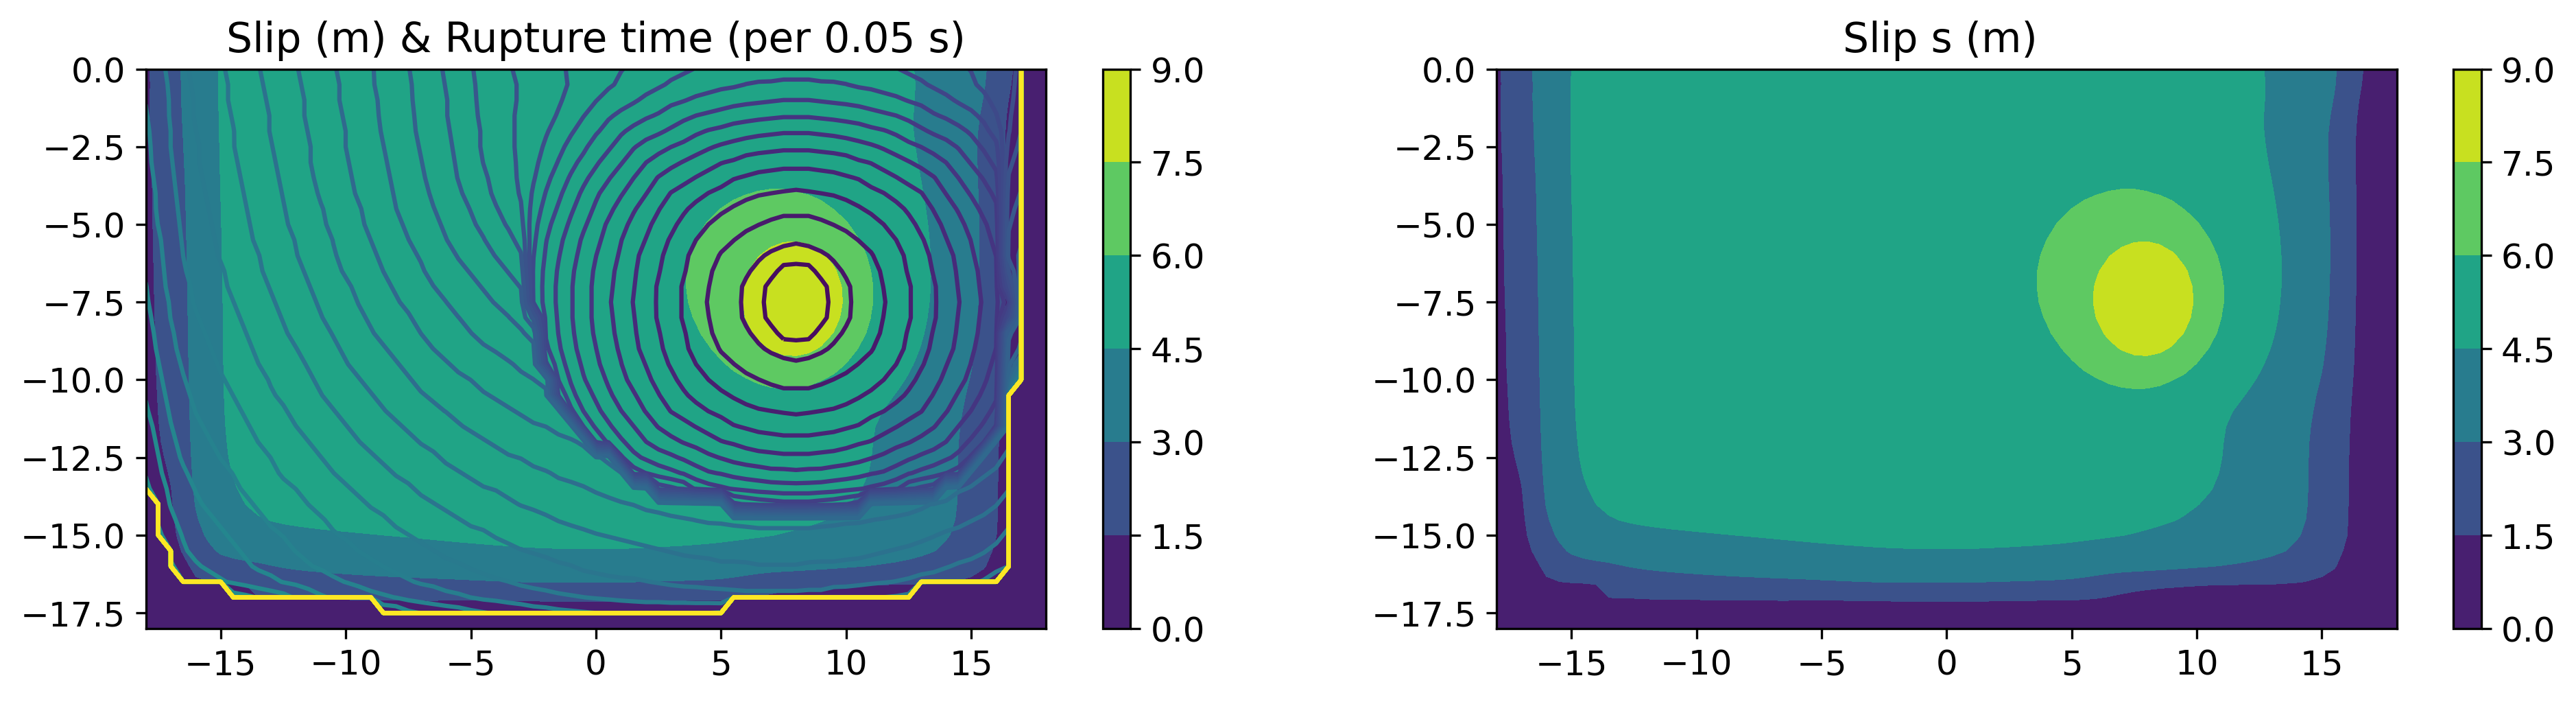

In [1]:
#!/usr/bin/env python3
"""
1. Plot on fault rupture dynamics.
2. Generate SCECRuptureTime.txt for benchmarking.
"""
import numpy as np
from math    import *
from user_defined_params import par
from os.path import exists
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import netCDF4 as nc
#
SMALL_SIZE = 12

def ruptureDynamics():
    nprocs = par.nx*par.ny*par.nz
    na     = round((par.fxmax-par.fxmin)/par.dx+1)
    ma     = round((par.fzmax-par.fzmin)/par.dz+1)
    rupt   = np.zeros((na*ma,3))
    rupt2d = np.zeros((ma,na,100))
    fVarArr= np.zeros((ma,na,100))
 
    [xx,zz] = np.meshgrid(par.fx,par.fz/sin(par.dip/180.*pi))
    xx = xx/1.e3
    zz = zz/1.e3#/sin(par.dip/180.*pi) # along dip distance
    moment = 0.
    
    for me in range(nprocs):
      fname = 'frt.txt' + str(me)
      if exists(fname):
        print('Post-processing ' + fname + ' ... ...')
        a = np.loadtxt(fname)
        n, m = a.shape
        for i in range(n):
            #!! use round() instead of int()!!
            ii = round((a[i,0] - par.fxmin)/par.dx)
            jj = round((a[i,2] - par.fzmin)/par.dz)
            
            # frt.txt* file structure:
            # Starting from 1, 1-3: coorx,y,z
            # 4, rupture time
            # 5-9,  final slips,d,n, 
            #       final sliprates,d.
            # 10,   peak slip rate.
            # 11,   final sliprate magnitude
            # 12-14, final tnrm, tstk, tdip
            # 15-20, vxm,vym,vzm,
            #        vxs,vys,vzs.
            # 21,   state variable
            # 22,   state var for normal stress variation (Shi and Day)
            
            rupt[jj*na+ii,0] = a[i,0]  # xcoor
            rupt[jj*na+ii,1] = -a[i,2]/sin(par.dip/180.*pi) # zcoor to along dip distance, reverse sign to positive numbers.
            rupt[jj*na+ii,2] = a[i,3]  # rupture time

            rupt2d[jj,ii,0]  = a[i,3]  # rupture time
            rupt2d[jj,ii,1]  = (a[i,4]**2 + a[i,5]**2)**0.5  # slip magnitude
            rupt2d[jj,ii,2]  = a[i,9]                        # peak slip rate
            rupt2d[jj,ii,3]  = a[i,10]                       # final slip rate
            shearMod = 3464**2*2800
            moment = moment + rupt2d[jj,ii,1]*par.dx*par.dx*shearMod
            rupt2d[jj,ii,4]  = a[i,12]/1.e6 # final shear stress
            rupt2d[jj,ii,5]  = a[i,11]/1.e6 # final normal stress
            rupt2d[jj,ii,6]  = a[i,13]/1.e6 # final dip shear
            rupt2d[jj,ii,7]  = a[i,4] # final slip s
            rupt2d[jj,ii,8]  = a[i,5] # final slip d

            # 
            # fVarArr will be passed to the function generateNcRestart(faultVarArr):
            fVarArr[jj,ii,0]  = a[i,12] # shear_strike, Pa
            fVarArr[jj,ii,1]  = a[i,13] # shear_dip, Pa
            fVarArr[jj,ii,2]  = a[i,11] # effective_normal, Pa 
            fVarArr[jj,ii,3]  = a[i,10] # slip_rate, m/s
            fVarArr[jj,ii,4]  = a[i,20] # state_variable
            fVarArr[jj,ii,5]  = a[i,21] # state_normal
            fVarArr[jj,ii,6]  = a[i,14] # vxm, m/s
            fVarArr[jj,ii,7]  = a[i,15] # vym
            fVarArr[jj,ii,8]  = a[i,16] # vzm
            fVarArr[jj,ii,9]  = a[i,17] # vxs
            fVarArr[jj,ii,10] = a[i,18] # vys
            fVarArr[jj,ii,11] = a[i,19] # vzs

    magnitude = 2/3*log10(moment*1.e7)-10.7
    
    levels = np.linspace(0,30,60) 
    #dt     = 30/60
    fig = plt.figure(figsize=(24,12), dpi= 300, facecolor='w', edgecolor='k')

    plt.rc('font', size=SMALL_SIZE)
    ax11 = fig.add_subplot(331)
    plt.contourf(xx,zz,rupt2d[:,:,1])
    plt.colorbar()
    plt.contour(xx,zz,rupt2d[:,:,0], levels)
    plt.title('Slip (m) & Rupture time (per 0.05 s)')

    ax12 = fig.add_subplot(332)
    plt.contourf(xx,zz,rupt2d[:,:,7])
    plt.colorbar()
    plt.title('Slip s (m) ')

    return rupt2d
    
src_res = ruptureDynamics()

In [2]:
#! /usr/bin/env python3
import numpy as np
import os, sys
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

class genMapsForEQDYNA:
    def __init__(self, mapType='gm', timeInSec=5, gmComp='strike', cmap='plasma', dim=2):    
        from user_defined_params import par

        self.gmSamplingRate = 1
        self.dt = par.dt*self.gmSamplingRate
        self.T = par.term
        self.dtype = np.float64
        self.valueSize = np.dtype(self.dtype).itemsize
        self.timeStepId = round(timeInSec/self.dt)
        self.timeInSec = timeInSec
        
        self.mapType = mapType
        self.cmap = cmap
        self.dim = dim

        self.dx = par.dx/1e3
        self.dy = par.dy/1e3
        self.dz = par.dz/1e3

        self.fig = plt.figure(figsize=(8,8))
        self.cbMax = 1 #(m/s)
        self.cbMin = -1 #(m/s)
        self.alpha = 1

        if self.mapType == 'gm':
            self.mapTypeToProcess = ['gm']
            self.dataFileNamePrefix = ['gm']
            self.stLocFileNamePrefix = ['surface_coor.txt']
            self.nValue = [3]
            self.xAxisId = 0 
            self.yAxisId = 1
            self.varLegend = 'Particle velocity (m/s)'
            self.titlePrefix = 'Ground Motion at '
        elif self.mapType == 'src':
            self.mapTypeToProcess = ['src']
            self.dataFileNamePrefix = ['src_evol']
            self.stLocFileNamePrefix = ['frt.txt']
            self.nValue = [1]
            self.xAxisId = 0
            self.yAxisId = 2
            self.varLegend = ['Slip rate (m/s)']
            self.titlePrefix = 'Source at '
        elif self.mapType == 'gm+src':
            if self.dim !=3:
                sys.exit("gm+src map is only available for 3-D map; exiting ...")

            self.mapTypeToProcess = ["gm", "src"]
            self.dataFileNamePrefix = ['gm','src_evol']
            self.stLocFileNamePrefix = ['surface_coor.txt','frt.txt']
            self.nValue = [3,1]
            self.varLegend = 'Particle velocity (m/s) + Slip rate (m/s)'
            self.titlePrefix = ''
        else:
            print("Invalid map type; exiting ...")
            sys.exit(1)

        if gmComp=='strike':
            self.gmCompId = 0
        elif gmComp=='norm':
            self.gmCompId = 1
        elif gmComp=='vert':
            self.gmCompId = 2
        else:
            print("Invalid gm component; exiting ...")
            sys.exit(1)

    def genMap(self):
        nTag = 0
        for iMapType, mapType in enumerate(self.mapTypeToProcess):
            for chunkId in range(1000):
                dataFileName = self.dataFileNamePrefix[iMapType] + str(chunkId)
                stLocFileName = self.stLocFileNamePrefix[iMapType] + str(chunkId)
                if os.path.isfile(dataFileName):
                    stLoc = np.loadtxt(stLocFileName)
                    numOfSt = stLoc.shape[0]
                    map = np.zeros((stLoc.shape[0],4))
                    map[:,:3] = stLoc[:,:3]
                    startIndex = self.timeStepId*numOfSt*self.nValue[iMapType]
                    
                    with open(dataFileName, 'rb') as f:
                        for i in range(numOfSt):
                            index = startIndex + i*self.nValue[iMapType]
                            f.seek(index*self.valueSize)
                            values = np.fromfile(f, dtype=self.dtype, count=self.nValue[iMapType]) 
                            if mapType == 'gm':
                                map[i,3] = values[self.gmCompId]
                            else:
                                map[i,3] = values

                    if nTag==0: 
                        self.fullMap = map
                    else:
                        self.fullMap = np.vstack((self.fullMap, map))
                    nTag += 1
        self.fullMap[:,:3] = self.fullMap[:,:3]/1e3
        np.savetxt(self.mapType+str(self.timeStepId)+'.txt', np.vstack(self.fullMap), delimiter='\t', fmt='%.6f')
        
        return self.fullMap
    
    #def saveMap(self):
    #    np.savetxt(self.mapType+str(self.timeInSec)+'.txt', np.vstack(self.fullMap), delimiter='\t', fmt='%.6f')
    
    def plotMap(self):
        if self.dim == 2: 
            mapXmin, mapXmax = self.fullMap[:,self.xAxisId].min(), self.fullMap[:,self.xAxisId].max()
            mapYmin, mapYmax = self.fullMap[:,self.yAxisId].min(), self.fullMap[:,self.yAxisId].max()
            nx = round((mapXmax - mapXmin)/self.dx)
            ny = round((mapYmax - mapYmin)/self.dy)
            xi = np.linspace(mapXmin, mapXmax, num=nx)
            yi = np.linspace(mapYmin, mapYmax, num=ny)
            xi, yi = np.meshgrid(xi, yi) 
            values = griddata((self.fullMap[:,self.xAxisId], self.fullMap[:,self.yAxisId]), self.fullMap[:,3], (xi, yi), method='linear')
                    
            ax = self.fig.add_subplot()
            plt.pcolormesh(xi, yi, values, cmap=self.cmap)
            plt.colorbar()
            ax.set_xlabel('Along-strike (km)', fontsize=12, fontweight='bold')
            ax.set_ylabel('Fault-normal (km)', fontsize=12, fontweight='bold')
            ax.axis('equal')
            ax.set_title(self.titlePrefix+' t='+str(self.timeInSec)+' s', fontsize=12, fontweight='bold')
            #plt.show()
            plt.savefig(f'gMap'+self.titlePrefix+'-t='+str(self.timeInSec)+'-s.png', dpi=300)

        elif self.dim == 3:
            ax = self.fig.add_subplot(111, projection='3d')
            sc = ax.scatter(self.fullMap[:,0], self.fullMap[:,1], self.fullMap[:,2], c=self.fullMap[:,3], cmap=self.cmap, vmin=self.cbMin, vmax=self.cbMax, alpha=self.alpha)
            cbar = plt.colorbar(sc, ax=ax, label=self.varLegend, orientation='horizontal', fraction=0.02, pad=0.1)
            ax.set_xlabel('Along-strike (km)', fontsize=12, fontweight='bold')
            ax.set_ylabel('Fault-normal (km)', fontsize=12, fontweight='bold')
            ax.set_zlabel('Up (km)', fontsize=12, fontweight='bold')
            ax.set_title(self.titlePrefix+' t='+str(self.timeInSec)+' s', fontsize=12, fontweight='bold')
            ax.tick_params(axis='both', which='major', labelsize=10, width=1.5)
            ax.grid(True, linewidth=1.5)

            ax.axis('equal')
            ax.view_init(elev=-15, azim=-150)
            #plt.show()
            plt.savefig(f'gMap'+self.titlePrefix+'-t='+str(self.timeInSec)+'-s.png', dpi=300)


In [3]:
def create_train_data(caseName):
    os.system('cd caseName')
    
    scale =500/10;
    map_generator = genMapsForEQDYNA(mapType='src', timeInSec=1, gmComp='strike', cmap='inferno', dim=3)
    print(map_generator.dt)
    dt = map_generator.dt
    timestep = round(15/dt)-1
    print(timestep)
    for i in range(timestep):  
        map_generator = genMapsForEQDYNA(mapType='src', timeInSec=i*dt+dt, gmComp='strike', cmap='inferno', dim=3)
        map_generator.genMap()

    tmp = np.loadtxt('src1.txt')
    nrow, ncol = tmp.shape
    print(nrow, ncol)
    train = np.zeros((timestep, nrow, 2))
    pos0 = np.zeros(nrow)
    pos = np.zeros(nrow)
    for i in range(timestep):
        tmp = np.loadtxt('src'+str(i+1)+'.txt')
        if i == 0:
            train[i,:,0] = tmp[:,3]*dt + tmp[:,0]*1e3/scale # update x position, along strike
            train[i,:,1] = 0.0 + tmp[:,2]*1e3/scale # update z position, along strike
        else:
            train[i,:,0] = tmp[:,3]*dt + train[i-1,:,0] # update x position, along strike
            train[i,:,1] = 0.0 + train[i-1,:,1] # update z position, along strike
    
    # Create a dictionary to store the data with the key 'tj1'
    data_dict = {'simulation_trajectory_0': train}
    
    # Save the dictionary to a .npz file
    #np.savez('train.npz', **data_dict)
    os.system('cd ..')

    return data_dict

0.041666666666666664
359


/var/folders/2h/7rlv1ry943j2tkpq1lc1gqrc0000gq/T/ipykernel_85630/3415601746.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  map[i,3] = values
/var/folders/2h/7rlv1ry943j2tkpq1lc1gqrc0000gq/T/ipykernel_85630/3415601746.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(figsize=(8,8))


<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

In [13]:
print(train)

[[[-360. -360.]
  [-360. -350.]
  [-360. -340.]
  ...
  [ 360.  -20.]
  [ 360.  -10.]
  [ 360.    0.]]

 [[-360. -360.]
  [-360. -350.]
  [-360. -340.]
  ...
  [ 360.  -20.]
  [ 360.  -10.]
  [ 360.    0.]]

 [[-360. -360.]
  [-360. -350.]
  [-360. -340.]
  ...
  [ 360.  -20.]
  [ 360.  -10.]
  [ 360.    0.]]

 ...

 [[-360. -360.]
  [-360. -350.]
  [-360. -340.]
  ...
  [ 360.  -20.]
  [ 360.  -10.]
  [ 360.    0.]]

 [[-360. -360.]
  [-360. -350.]
  [-360. -340.]
  ...
  [ 360.  -20.]
  [ 360.  -10.]
  [ 360.    0.]]

 [[-360. -360.]
  [-360. -350.]
  [-360. -340.]
  ...
  [ 360.  -20.]
  [ 360.  -10.]
  [ 360.    0.]]]


In [15]:
traj_0 = data_dict['simulation_trajectory_0']
coordinates_0 = traj_0  # the 3D array (N, M, 2)
labels_0 = traj_0      # the 1D array of 5s
print(coordinates_0.shape)  # something like (500, 100, 2) maybe?
print(labels_0.shape)       # maybe (500,)

(359, 2738, 2)
(359, 2738, 2)
